# Загрузка библиотек

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Input, Dense, Flatten, Conv3DTranspose, concatenate, Activation, MaxPooling3D, GlobalMaxPooling3D,GlobalAveragePooling3D, Conv3D, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import keras
import numpy as np
from keras import utils as np_utils
from matplotlib import pyplot as plt
import cv2
from random import  randint
from tqdm import tqdm
import os
import json, codecs

# Подготовка тренировочных наборов

In [ ]:
params = {'dim': (20,80,80),
          'batch_size': 32,
          'n_classes': 7,
          'n_channels': 1,
          'shuffle': True}

In [ ]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, part,list_IDs, batch_size, dim=(20,80,80), n_channels=1,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.part = part
        self.dim = dim
        self.batch_size = batch_size

        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            try:
              X[i,] = np.load('vkr_npy/' + self.part + '/' +ID)
            # Store class
              y[i] = int(ID[0])
            except:
              print(ID)

        return X.reshape(X.shape[0],*self.dim, 1),keras.utils.np_utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
path = 'vkr_npy/Train/'
# чтение записей
listID_train=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_train.append(entry.name)

path = 'vkr_npy/Val/'
# чтение записей
listID_val=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_val.append(entry.name)

path = 'vkr_npy/Test/'
# чтение записей
listID_test=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_test.append(entry.name)


In [ ]:
training_generator = DataGenerator('Train',listID_train, 32)
validation_generator = DataGenerator('Val',listID_val,32)
test_generator = DataGenerator('test',listID_test,150 )

# Функции

In [ ]:
# Для ппостроения графиков обучения
def plot_history(history): #Создание полотна для рисунка
    plt.figure(1, figsize=(18, 5))

    # Задание первой (левой) области для построения графиков
    plt.subplot(1, 2, 1)
    # Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
    plt.plot(history['loss'],
            label='Значение ошибки на обучающем наборе')
    plt.plot(history['val_loss'],
            label='Значение ошибки на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Значение ошибки')
    plt.legend()

    # Задание второй (правой) области для построения графиков
    plt.subplot(1, 2, 2)
    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    plt.plot(history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()

    # Фиксация графиков и рисование всей картинки
    plt.show()

In [ ]:
# Для сохранения истории обучения
class float32_encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return obj.astype(np.float64)
        return json.JSONEncoder.default(self, obj)

def saveHist(path, history):
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history, f, separators=(',', ':'), sort_keys=True, indent=4,cls=float32_encoder)

def loadHist(path):
    n = {} # set history to empty
    if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
            n = json.loads(f.read())
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

# Модель с выпрямляющим слоем GlobalMaxPooling3D

In [ ]:
# функция создания модели
def unet(class_count,   # количество классов = 7
         input_shape    # форма входного изображения 20*80*80*1
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv3D(8, (8, 8, 8), padding='same', name='block1_conv1')(img_input)  # форма 20*80*80*8
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(8, (8, 8, 8), padding='same', name='block1_conv2')(x)          # Добавляем Conv3D-слой с 8-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling3D()(block_1_out)                                         #10*40*40*8

    ''' Block 2 '''
    x = Conv3D(16, (6, 6,6), padding='same', name='block2_conv1')(x)         # 10*40*40*16
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(16, (6, 6,6), padding='same', name='block2_conv2')(x)         # Добавляем Conv3D-слой с 16-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling3D()(block_2_out)                                         # 5*20*20*16
    ''' Block 3 '''
    x = Conv3D(32, (4, 4, 4), padding='same', name='block3_conv1')(x)        # 5*20*20*32
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(32, (4, 4, 4), padding='same', name='block3_conv2')(x)        # Добавляем Conv3D-слой с 32-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling3D(pool_size = 5)(block_3_out)                            #  1*4*4*32

    ''' Block 4 '''
    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv1')(x)         # 1*4*4*64
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv2')(x)         # Добавляем Conv3D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv3')(x)         # Добавляем Conv3D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization

    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out

    x = block_4_out

    ''' UP1 '''
    x = Conv3DTranspose(32, (4, 4, 4), strides=(5,5,5), padding='same')(x)     # 5*20*20*32
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv3D(32, (4, 4, 4), padding='same')(x)                              # Добавляем слой Conv3D с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(32, (4, 4, 4), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP2 '''
    x = Conv3DTranspose(16, (6, 6, 6), strides=(2, 2, 2), padding='same')(x)# 10*40*40*16
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv3D(16, (6, 6, 6), padding='same')(x)                              # Добавляем слой Conv3D с 16 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(16, (6, 6, 6), padding='same')(x)                              # Добавляем слой Conv3D с 16 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP3 '''
    x = Conv3DTranspose(8, (8, 8, 8), strides=(2, 2,2), padding='same')(x)  # 20*80*80*8
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out

    x = Conv3D(8, (8, 8, 8), padding='same')(x)                               # Добавляем слой Conv3D с 8 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(8, (8, 8, 8), padding='same')(x)                               # Добавляем слой Conv3D с 8 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation
    x = GlobalMaxPooling3D()(x)
    x = Dense(7,  activation ='softmax')(x)
    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Nadam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
model_unet = unet(7, (20,80,80,1))# создаем модель

## Обучение сети

In [ ]:
history_unet = model_unet.fit(training_generator,
                         epochs=50, validation_data=validation_generator)

Epoch 1/50
187/187 [==============================] - 378s 2s/step - loss: 2.0827 - accuracy: 0.1564 - val_loss: 1.9277 - val_accuracy: 0.2165
Epoch 2/50
187/187 [==============================] - 326s 2s/step - loss: 1.9208 - accuracy: 0.2034 - val_loss: 4.6591 - val_accuracy: 0.1897
Epoch 3/50
187/187 [==============================] - 329s 2s/step - loss: 1.8735 - accuracy: 0.2112 - val_loss: 1.8838 - val_accuracy: 0.2359
Epoch 4/50
187/187 [==============================] - 329s 2s/step - loss: 1.8558 - accuracy: 0.2208 - val_loss: 1.8803 - val_accuracy: 0.2396
Epoch 5/50
187/187 [==============================] - 329s 2s/step - loss: 1.8243 - accuracy: 0.2309 - val_loss: 1.8637 - val_accuracy: 0.2091
Epoch 6/50
187/187 [==============================] - 329s 2s/step - loss: 1.7982 - accuracy: 0.2537 - val_loss: 1.8790 - val_accuracy: 0.2180
Epoch 7/50
187/187 [==============================] - 329s 2s/step - loss: 1.7692 - accuracy: 0.2704 - val_loss: 1.8674 - val_accuracy: 0.2478

In [ ]:
model_unet.summary()

In [ ]:
saveHist('vkr/history_unet_bs32_Nadam.json', history_unet.history)

In [ ]:
# Коллбэки
def scheduler(epoch, lr):# Расписание изменения Lr
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/unet_bs32_Nadam_2_{epoch:03D}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history_unet2 = model_unet.fit(training_generator,
                         epochs=50, validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/50
187/187 [==============================] - 330s 2s/step - loss: 0.4086 - accuracy: 0.8585 - val_loss: 1.0372 - val_accuracy: 0.6860
Epoch 2/50
187/187 [==============================] - 330s 2s/step - loss: 0.3497 - accuracy: 0.8782 - val_loss: 0.9567 - val_accuracy: 0.7217
Epoch 3/50
187/187 [==============================] - 330s 2s/step - loss: 0.3784 - accuracy: 0.8712 - val_loss: 1.2145 - val_accuracy: 0.6503
Epoch 4/50
187/187 [==============================] - 330s 2s/step - loss: 0.3177 - accuracy: 0.8912 - val_loss: 1.0782 - val_accuracy: 0.6868
Epoch 5/50
187/187 [==============================] - 330s 2s/step - loss: 0.3391 - accuracy: 0.8834 - val_loss: 1.1167 - val_accuracy: 0.6853
Epoch 6/50
187/187 [==============================] - 330s 2s/step - loss: 0.3158 - accuracy: 0.8912 - val_loss: 1.1936 - val_accuracy: 0.6667
Epoch 7/50
187/187 [==============================] - 330s 2s/step - loss: 0.3008 - accuracy: 0.9027 - val_loss: 0.9419 - val_accuracy: 0.7426

In [ ]:
saveHist('vkr/history_unet_bs32_Nadam_2.json', history_unet2.history)

In [ ]:
round(model_unet.optimizer.lr.numpy(), 15)

0.00018268332

In [ ]:
model_unet.load_weights('vkr/unet_bs32_Nadam_2_23-0.77.hdf5')

model_unet.compile(optimizer=Nadam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/unet_bs32_Nadam_3_{epoch:03D}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history_unet3 = model_unet.fit(training_generator,
                         epochs=50, validation_data=validation_generator)

In [ ]:
saveHist('vkr/history_unet_bs32_Nadam_3.json', history_unet3.history)

In [ ]:
history_u1 = loadHist('vkr/history_unet_bs32_Nadam.json')

In [ ]:
history_u2 = loadHist('vkr/history_unet_bs32_Nadam_2.json')

In [ ]:
history_u = appendHist(history_u1,history_u2)

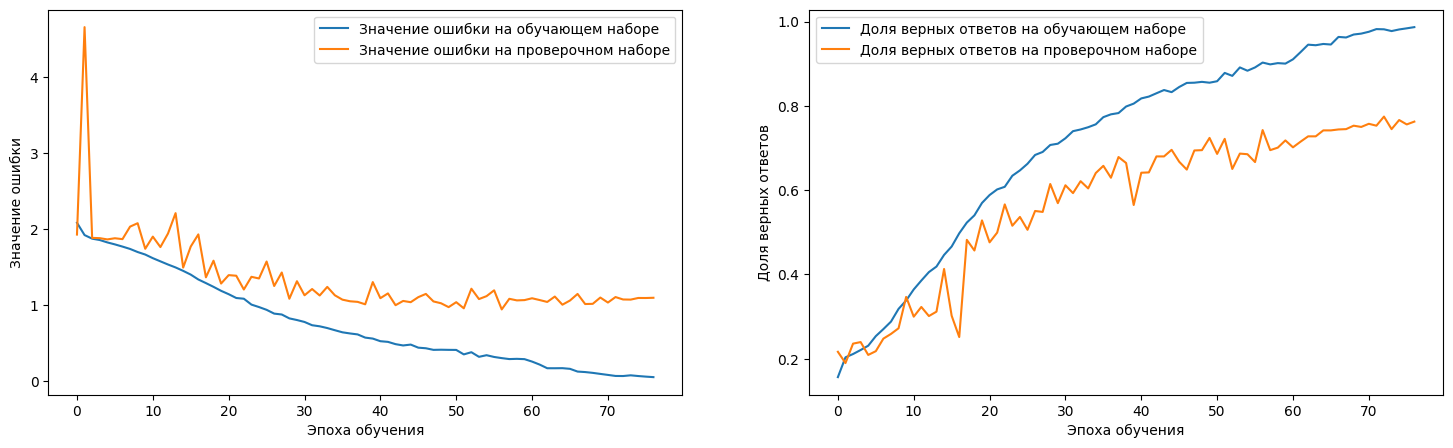

In [ ]:
plot_history(history_u)

Точность первой модели - 77%

# Модель с выпрямляющим слоем Flatten

In [ ]:
def unet2(class_count,   # количество классов = 7
         input_shape    # форма входного изображения 20*80*80*1
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv3D(8, (8, 8, 8), padding='same', name='block1_conv1')(img_input)  # форма 20*80*80*8
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(8, (8, 8, 8), padding='same', name='block1_conv2')(x)          # Добавляем Conv3D-слой с 8-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling3D()(block_1_out)                                         #10*40*40*8

    ''' Block 2 '''
    x = Conv3D(16, (6, 6,6), padding='same', name='block2_conv1')(x)         # 10*40*40*16
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(16, (6, 6,6), padding='same', name='block2_conv2')(x)         # Добавляем Conv3D-слой с 16-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling3D()(block_2_out)                                         # 5*20*20*16
    ''' Block 3 '''
    x = Conv3D(32, (4, 4, 4), padding='same', name='block3_conv1')(x)        # 5*20*20*32
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(32, (4, 4, 4), padding='same', name='block3_conv2')(x)        # Добавляем Conv3D-слой с 32-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling3D(pool_size = 5)(block_3_out)                            #  1*4*4*32

    ''' Block 4 '''
    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv1')(x)         # 1*4*4*64
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv2')(x)         # Добавляем Conv3D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv3')(x)         # Добавляем Conv3D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization

    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out

    x = block_4_out

    ''' UP1 '''
    x = Conv3DTranspose(32, (4, 4, 4), strides=(5,5,5), padding='same')(x)     # 5*20*20*32
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv3D(32, (4, 4, 4), padding='same')(x)                              # Добавляем слой Conv3D с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(32, (4, 4, 4), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP2 '''
    x = Conv3DTranspose(16, (6, 6, 6), strides=(2, 2, 2), padding='same')(x)# 10*40*40*16
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv3D(16, (6, 6, 6), padding='same')(x)                              # Добавляем слой Conv3D с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(16, (6, 6, 6), padding='same')(x)                              # Добавляем слой Conv3D с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP3 '''
    x = Conv3DTranspose(8, (8, 8, 8), strides=(2, 2,2), padding='same')(x)  # 20*80*80*8
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out

    x = Conv3D(8, (8, 8, 8), padding='same')(x)                               # Добавляем слой Conv3D с8 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(8, (8, 8, 8), padding='same')(x)                               # Добавляем слой Conv3D с 8 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation
    #x = GlobalAveragePooling3D()(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(128,  activation ='relu')(x)
    x = Dense(7,  activation ='softmax')(x)

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Nadam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
model_unet_fl = unet2(7, (20,80,80,1))

In [ ]:
model_unet_fl.load_weights('vkr/unet_fl_bs32_Nadam_39-0.68.hdf5')

In [ ]:
model_unet_fl.compile(optimizer=Nadam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/unet_fl_bs32_Nadam_2_{epoch:03D}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

## Обучение сети

In [ ]:
history_unet_fl_2 = model_unet_fl.fit(training_generator,
                         epochs=100, validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/100
187/187 [==============================] - 400s 2s/step - loss: 0.2527 - accuracy: 0.8957 - val_loss: 2.0271 - val_accuracy: 0.6771
Epoch 2/100
187/187 [==============================] - 353s 2s/step - loss: 0.2435 - accuracy: 0.8991 - val_loss: 2.1888 - val_accuracy: 0.6696
Epoch 3/100
187/187 [==============================] - 353s 2s/step - loss: 0.2391 - accuracy: 0.8999 - val_loss: 2.4026 - val_accuracy: 0.6711
Epoch 4/100
187/187 [==============================] - 353s 2s/step - loss: 0.2398 - accuracy: 0.9006 - val_loss: 2.8305 - val_accuracy: 0.6726
Epoch 5/100
187/187 [==============================] - 353s 2s/step - loss: 0.2321 - accuracy: 0.9042 - val_loss: 2.4737 - val_accuracy: 0.6719
Epoch 6/100
187/187 [==============================] - 353s 2s/step - loss: 0.2295 - accuracy: 0.9037 - val_loss: 2.3424 - val_accuracy: 0.6674
Epoch 7/100
187/187 [==============================] - 353s 2s/step - loss: 0.2265 - accuracy: 0.9074 - val_loss: 2.4274 - val_accuracy:

In [ ]:
saveHist('vkr/history_unet_fl_2.json', history_unet_fl_2.history)

In [ ]:
hist_ufl1 = loadHist('vkr/history_unet_fl.json')

In [ ]:
hist_ufl = appendHist(hist_ufl1,history_unet_fl_2.history)

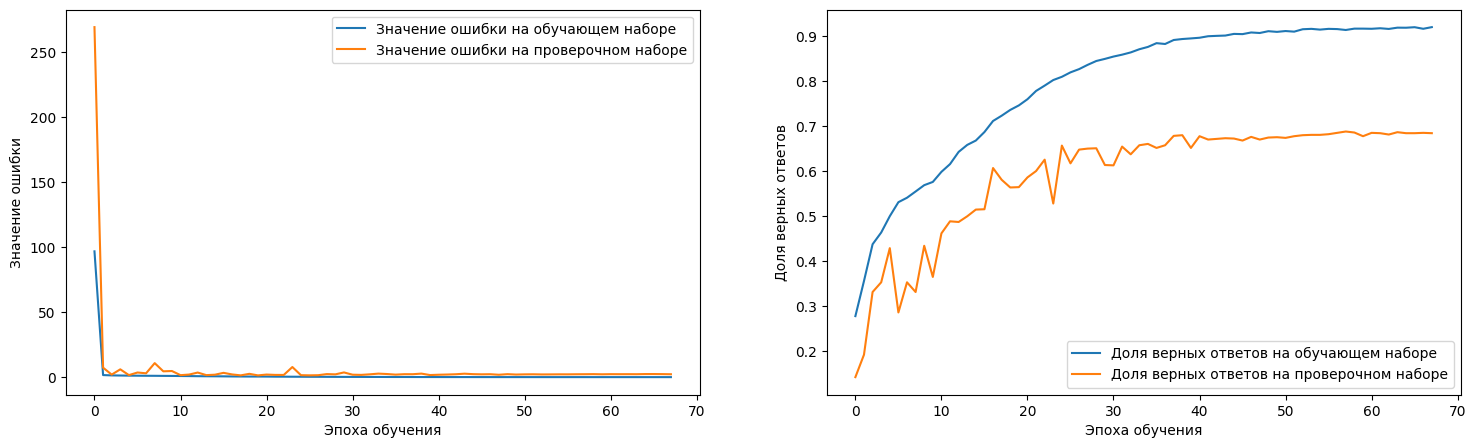

In [ ]:
plot_history(hist_ufl)

Точность второй модели - 69%, результат хуже, чем у первой.

# Модель с выпрямляющим слоем GlobalAveragePooling3D

In [ ]:
def unet3(class_count,   # количество классов = 7
         input_shape    # форма входного изображения 20*80*80*1
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv3D(8, (8, 8, 8), padding='same', name='block1_conv1')(img_input)  # форма 20*80*80*8
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(8, (8, 8, 8), padding='same', name='block1_conv2')(x)          # Добавляем Conv3D-слой с 8-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling3D()(block_1_out)                                         #10*40*40*8

    ''' Block 2 '''
    x = Conv3D(16, (6, 6,6), padding='same', name='block2_conv1')(x)         # 10*40*40*16
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(16, (6, 6,6), padding='same', name='block2_conv2')(x)         # Добавляем Conv3D-слой с 16-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling3D()(block_2_out)                                         # 5*20*20*16
    ''' Block 3 '''
    x = Conv3D(32, (4, 4, 4), padding='same', name='block3_conv1')(x)        # 5*20*20*32
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(32, (4, 4, 4), padding='same', name='block3_conv2')(x)        # Добавляем Conv3D-слой с 32-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling3D(pool_size = 5)(block_3_out)                            #  1*4*4*32

    ''' Block 4 '''
    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv1')(x)         # 1*4*4*64
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv2')(x)         # Добавляем Conv3D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(64, (2, 2,2), padding='same', name='block4_conv3')(x)         # Добавляем Conv3D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization

    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out

    x = block_4_out

    ''' UP1 '''
    x = Conv3DTranspose(32, (4, 4, 4), strides=(5,5,5), padding='same')(x)     # 5*20*20*32
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv3D(32, (4, 4, 4), padding='same')(x)                              # Добавляем слой Conv3D с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(32, (4, 4, 4), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP2 '''
    x = Conv3DTranspose(16, (6, 6, 6), strides=(2, 2, 2), padding='same')(x)# 10*40*40*16
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv3D(16, (6, 6, 6), padding='same')(x)                              # Добавляем слой Conv3D с 16 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(16, (6, 6, 6), padding='same')(x)                              # Добавляем слой Conv3D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP3 '''
    x = Conv3DTranspose(8, (8, 8, 8), strides=(2, 2,2), padding='same')(x)  # 20*80*80*8
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out

    x = Conv3D(8, (8, 8, 8), padding='same')(x)                               # Добавляем слой Conv3D с 8 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv3D(8, (8, 8, 8), padding='same')(x)                               # Добавляем слой Conv3D с 8 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation
    x = GlobalAveragePooling3D()(x)
    x = BatchNormalization()(x)
    x = Dense(128,  activation ='relu')(x)
    x = Dense(7,  activation ='softmax')(x)

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Nadam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
unet_gap = unet3(7, (20,80,80,1))

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/unet_gap_{epoch:03D}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

## Обучение сети

In [ ]:
history_unet_gap = unet_gap.fit(training_generator,
                         epochs=100, validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/100
187/187 [==============================] - 378s 2s/step - loss: 1.8781 - accuracy: 0.2269 - val_loss: 1.9253 - val_accuracy: 0.1786
Epoch 2/100
187/187 [==============================] - 331s 2s/step - loss: 1.8063 - accuracy: 0.2674 - val_loss: 2.8338 - val_accuracy: 0.1488
Epoch 3/100
187/187 [==============================] - 331s 2s/step - loss: 1.7450 - accuracy: 0.3018 - val_loss: 1.9571 - val_accuracy: 0.2351
Epoch 4/100
187/187 [==============================] - 331s 2s/step - loss: 1.6741 - accuracy: 0.3431 - val_loss: 2.0618 - val_accuracy: 0.3013
Epoch 5/100
187/187 [==============================] - 331s 2s/step - loss: 1.6211 - accuracy: 0.3703 - val_loss: 2.5707 - val_accuracy: 0.2500
Epoch 6/100
187/187 [==============================] - 331s 2s/step - loss: 1.5646 - accuracy: 0.3964 - val_loss: 1.8149 - val_accuracy: 0.3080
Epoch 7/100
187/187 [==============================] - 331s 2s/step - loss: 1.4941 - accuracy: 0.4241 - val_loss: 1.7725 - val_accuracy:

In [ ]:
saveHist('vkr/history_gap.json', history_unet_gap.history)

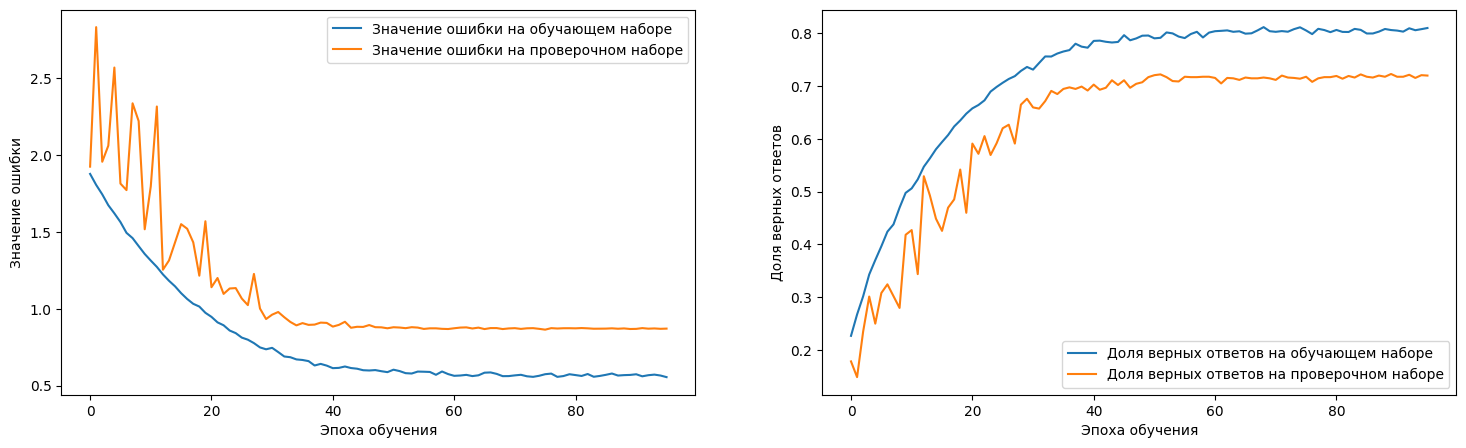

In [ ]:
plot_history(history_unet_gap.history)

Точночсть третьей модели - 72%.

# Вывод

Тип выпрямляющего слоя влияет на точность модели, максимальную точность (76%) показала сеть со слоем GlobalMaxPooling3D, на втором месте сеть со слоем GlobalAveragePooling3D (72%), сеть со слоем Flatten показала самый низкий показатель точности из трех моделей (69%).